<a href="https://colab.research.google.com/github/travislatchman/Cardiac-Ultrasound-Image-Segmentation-and-Stroke-Volume-estimation/blob/main/Cardiac_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import Reconstruction as Rec
import Segmentation as Seg
import pyvista as pv
import numpy as np
import re

def getVolumesForPatient(patient):
    types = ['2CH_ED', '2CH_ES', '4CH_ED', '4CH_ES']
    contours = []
    aspectRatio = 0
    for t in types: 
        image, aspect, spacing = Seg.read_patient_mhd_file(patient, t)
        b, region = Seg.segmentImage(image[0], aspect, t, False, False)
        contours.append(region.astype(np.uint8))
        if aspect != aspectRatio and aspectRatio > 0:
            raise Exception('Different Aspects')
        aspectRatio = aspect
        
    resampled = Rec.resampleAllContours(contours)

    ED = Rec.generatePointCloud(resampled[0], resampled[2], 4, aspectRatio, False)
    ES = Rec.generatePointCloud(resampled[1], resampled[3], 4, aspectRatio, False)
    
    EDsurface = pv.wrap(np.array(ED)).reconstruct_surface()
    ESsurface = pv.wrap(np.array(ES)).reconstruct_surface()

    
    fileInfo = Seg.read_patient_info_file(patient)
    parts = re.split(': |\n', fileInfo)
    iED = parts.index("LVedv")
    iES = parts.index("LVesv")
    
    return EDsurface.volume, ESsurface.volume, float(parts[iED+1]), float(parts[iES+1])

C:\Users\Leonhard\miniconda3\envs\MIA\lib\site-packages\numpy\lib\function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Leonhard\miniconda3\envs\MIA\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


20
40
60
80
100
120
140
160
180
200
220
240


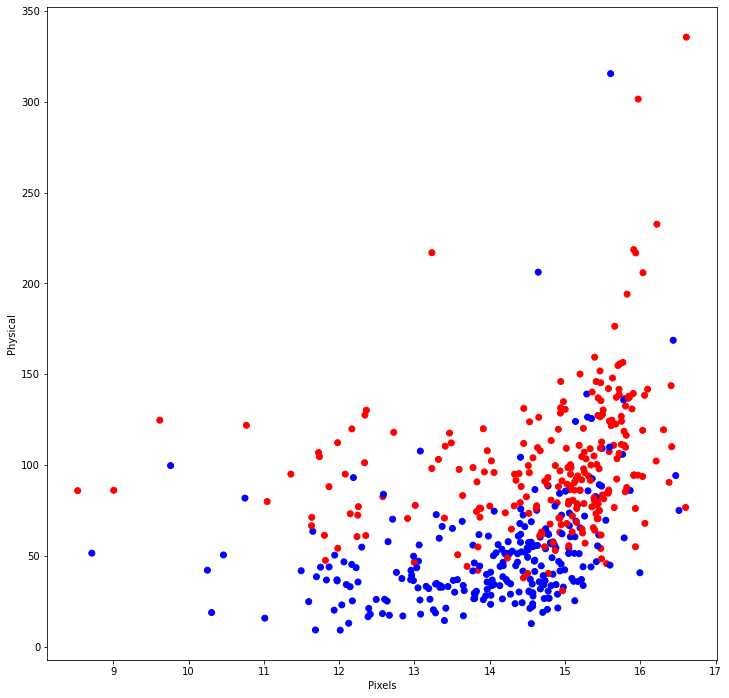

In [2]:
import matplotlib.pyplot as plt

pixels = []
physical = []
color = []
for patientNumber in range(1, 251):
    if patientNumber % 20 == 0:
        print(patientNumber)
    pixelED, pixelES, physicalED, physicalES = getVolumesForPatient(patientNumber)
    
    pixels.append(pixelED)
    physical.append(physicalED)
    color.append('red')
    
    pixels.append(pixelES)
    physical.append(physicalES)
    color.append('blue')
    
plt.figure(figsize=(12,10))
plt.xlabel('Pixels')
plt.ylabel('Physical')
plt.scatter(np.log(np.array(pixels)), physical, c=color)
plt.show()


**Testing to make sure that volume is actual volume and not bounding box volume**


In [7]:
import pyvista as pv

sphere = pv.Sphere(radius=1)
surface = sphere.reconstruct_surface()

print(surface.volume)
#True volume would be 4.18
#Bounding box would be 8

4.096869300268425


In [31]:
def regression(x, a, b, c):
    return a * np.exp(b * x) + c

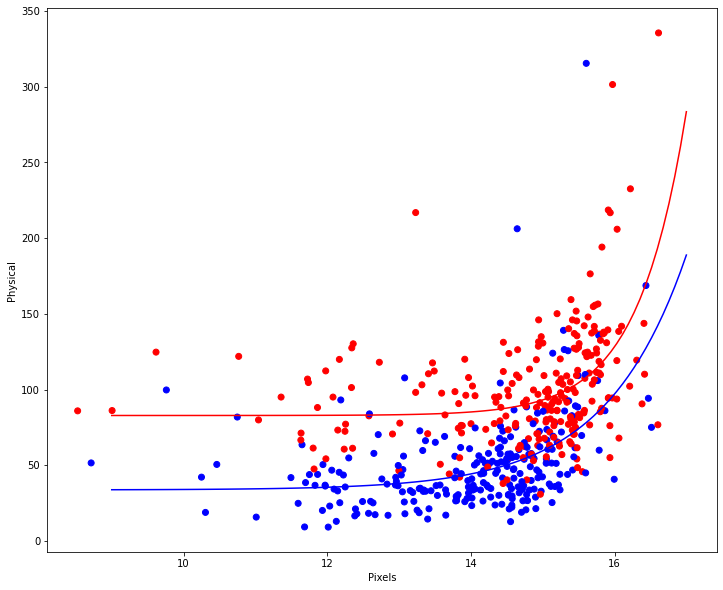

In [43]:
import numpy as np
from scipy.optimize import curve_fit

popt1, pcov1 = curve_fit(regression, np.log(np.array(pixels[::2])), physical[::2])
popt2, pcov2 = curve_fit(regression, np.log(np.array(pixels[1::2])), physical[1::2])

plt.figure(figsize=(12,10))
plt.xlabel('Pixels')
plt.ylabel('Physical')
plt.scatter(np.log(np.array(pixels)), physical, c=color)

t = np.linspace(9, 17, 100)
plt.plot(t, regression(t, *popt1), color='red')
plt.plot(t, regression(t, *popt2), color='blue')
plt.show()

In [45]:
import Reconstruction as Rec
import Segmentation as Seg
import pyvista as pv
import numpy as np
import re


opt1 = [2.15060547e-09, 1.48584167e+00, 8.28364558e+01]
opt2 = [3.76830004e-05, 8.95933170e-01, 3.36601220e+01]

def getVolumesForTest(patient):
    types = ['2CH_sequence', '4CH_sequence']
    contours = []
    aspectRatio = 0
    for t in types: 
        image, aspect, spacing = Seg.read_patient_mhd_file(patient, t, test=True)
        
        b, region = Seg.segmentImage(image[0], aspect, t, False, False)
        contours.append(region.astype(np.uint8))
        
        b, region = Seg.segmentImage(image[-1], aspect, t, False, False)
        contours.append(region.astype(np.uint8))
        if aspect != aspectRatio and aspectRatio > 0:
            raise Exception('Different Aspects')
        aspectRatio = aspect
        
        
    resampled = Rec.resampleAllContours(contours)

    ED = Rec.generatePointCloud(resampled[0], resampled[2], 4, aspectRatio, False)
    ES = Rec.generatePointCloud(resampled[1], resampled[3], 4, aspectRatio, False)
    
    EDsurface = pv.wrap(np.array(ED)).reconstruct_surface().volume
    ESsurface = pv.wrap(np.array(ES)).reconstruct_surface().volume

    EDreal = regression(np.log(EDsurface), *opt1)
    ESreal = regression(np.log(ESsurface), *opt2)
   
    return EDreal, ESreal, (EDreal - ESreal) / EDreal
    

for i in range(1, 11):
    print(getVolumesForTest(i))

(115.92943029661953, 80.28309345853349, 0.3074830674737257)


C:\Users\Leonhard\miniconda3\envs\MIA\lib\site-packages\numpy\lib\function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Leonhard\miniconda3\envs\MIA\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(100.17283160341623, 66.84581001934677, 0.33269521336894)
(83.34514225688473, 35.26688534041659, 0.5768573382271314)
(89.92508233561851, 41.48708356640461, 0.5386483671867383)
(96.66095399204359, 79.49353696199131, 0.17760446510247946)
(90.77357729320576, 45.72740083763441, 0.49624767249249935)
(89.1723382979109, 40.26454020773236, 0.5484637839907842)
(84.22457319162613, 36.343624641298234, 0.568491435882852)
(84.91028298087771, 65.34632536201336, 0.23040740098899762)
(99.84569921017231, 46.79918193914834, 0.531284949583683)
